In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Import Libraries

In [29]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from geopy.distance import distance

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout, Bidirectional

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/student-mat.csv').dropna()
data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


# 3. Initial Analysis

### 3.1. Metadata

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   school      395 non-null    int32
 1   sex         395 non-null    int32
 2   age         395 non-null    int64
 3   address     395 non-null    int32
 4   famsize     395 non-null    int32
 5   Pstatus     395 non-null    int32
 6   Medu        395 non-null    int64
 7   Fedu        395 non-null    int64
 8   Mjob        395 non-null    int32
 9   Fjob        395 non-null    int32
 10  reason      395 non-null    int32
 11  guardian    395 non-null    int32
 12  traveltime  395 non-null    int64
 13  studytime   395 non-null    int64
 14  failures    395 non-null    int64
 15  schoolsup   395 non-null    int32
 16  famsup      395 non-null    int32
 17  paid        395 non-null    int32
 18  activities  395 non-null    int32
 19  nursery     395 non-null    int32
 20  higher      395 non-null    int3

In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,395.0,16.696203,1.276043,15.0,16.0,17.0,18.0,22.0
Medu,395.0,2.749367,1.094735,0.0,2.0,3.0,4.0,4.0
Fedu,395.0,2.521519,1.088201,0.0,2.0,2.0,3.0,4.0
traveltime,395.0,1.448101,0.697505,1.0,1.0,1.0,2.0,4.0
studytime,395.0,2.035443,0.839240,1.0,1.0,2.0,2.0,4.0
failures,395.0,0.334177,0.743651,0.0,0.0,0.0,0.0,3.0
famrel,395.0,3.944304,0.896659,1.0,4.0,4.0,5.0,5.0
freetime,395.0,3.235443,0.998862,1.0,3.0,3.0,4.0,5.0
goout,395.0,3.108861,1.113278,1.0,2.0,3.0,4.0,5.0
Dalc,395.0,1.481013,0.890741,1.0,1.0,1.0,2.0,5.0


In [6]:
data.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [7]:
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of duplicates data : 0


### 3.2. Get columns dtypes

In [10]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Categorical Columns : []


In [9]:
LE = LabelEncoder()

for idx, column in enumerate(categorical_columns):
    data[column] = LE.fit_transform(data[column])
    data[column] = data[column].astype(int)

### 3.3. EDA

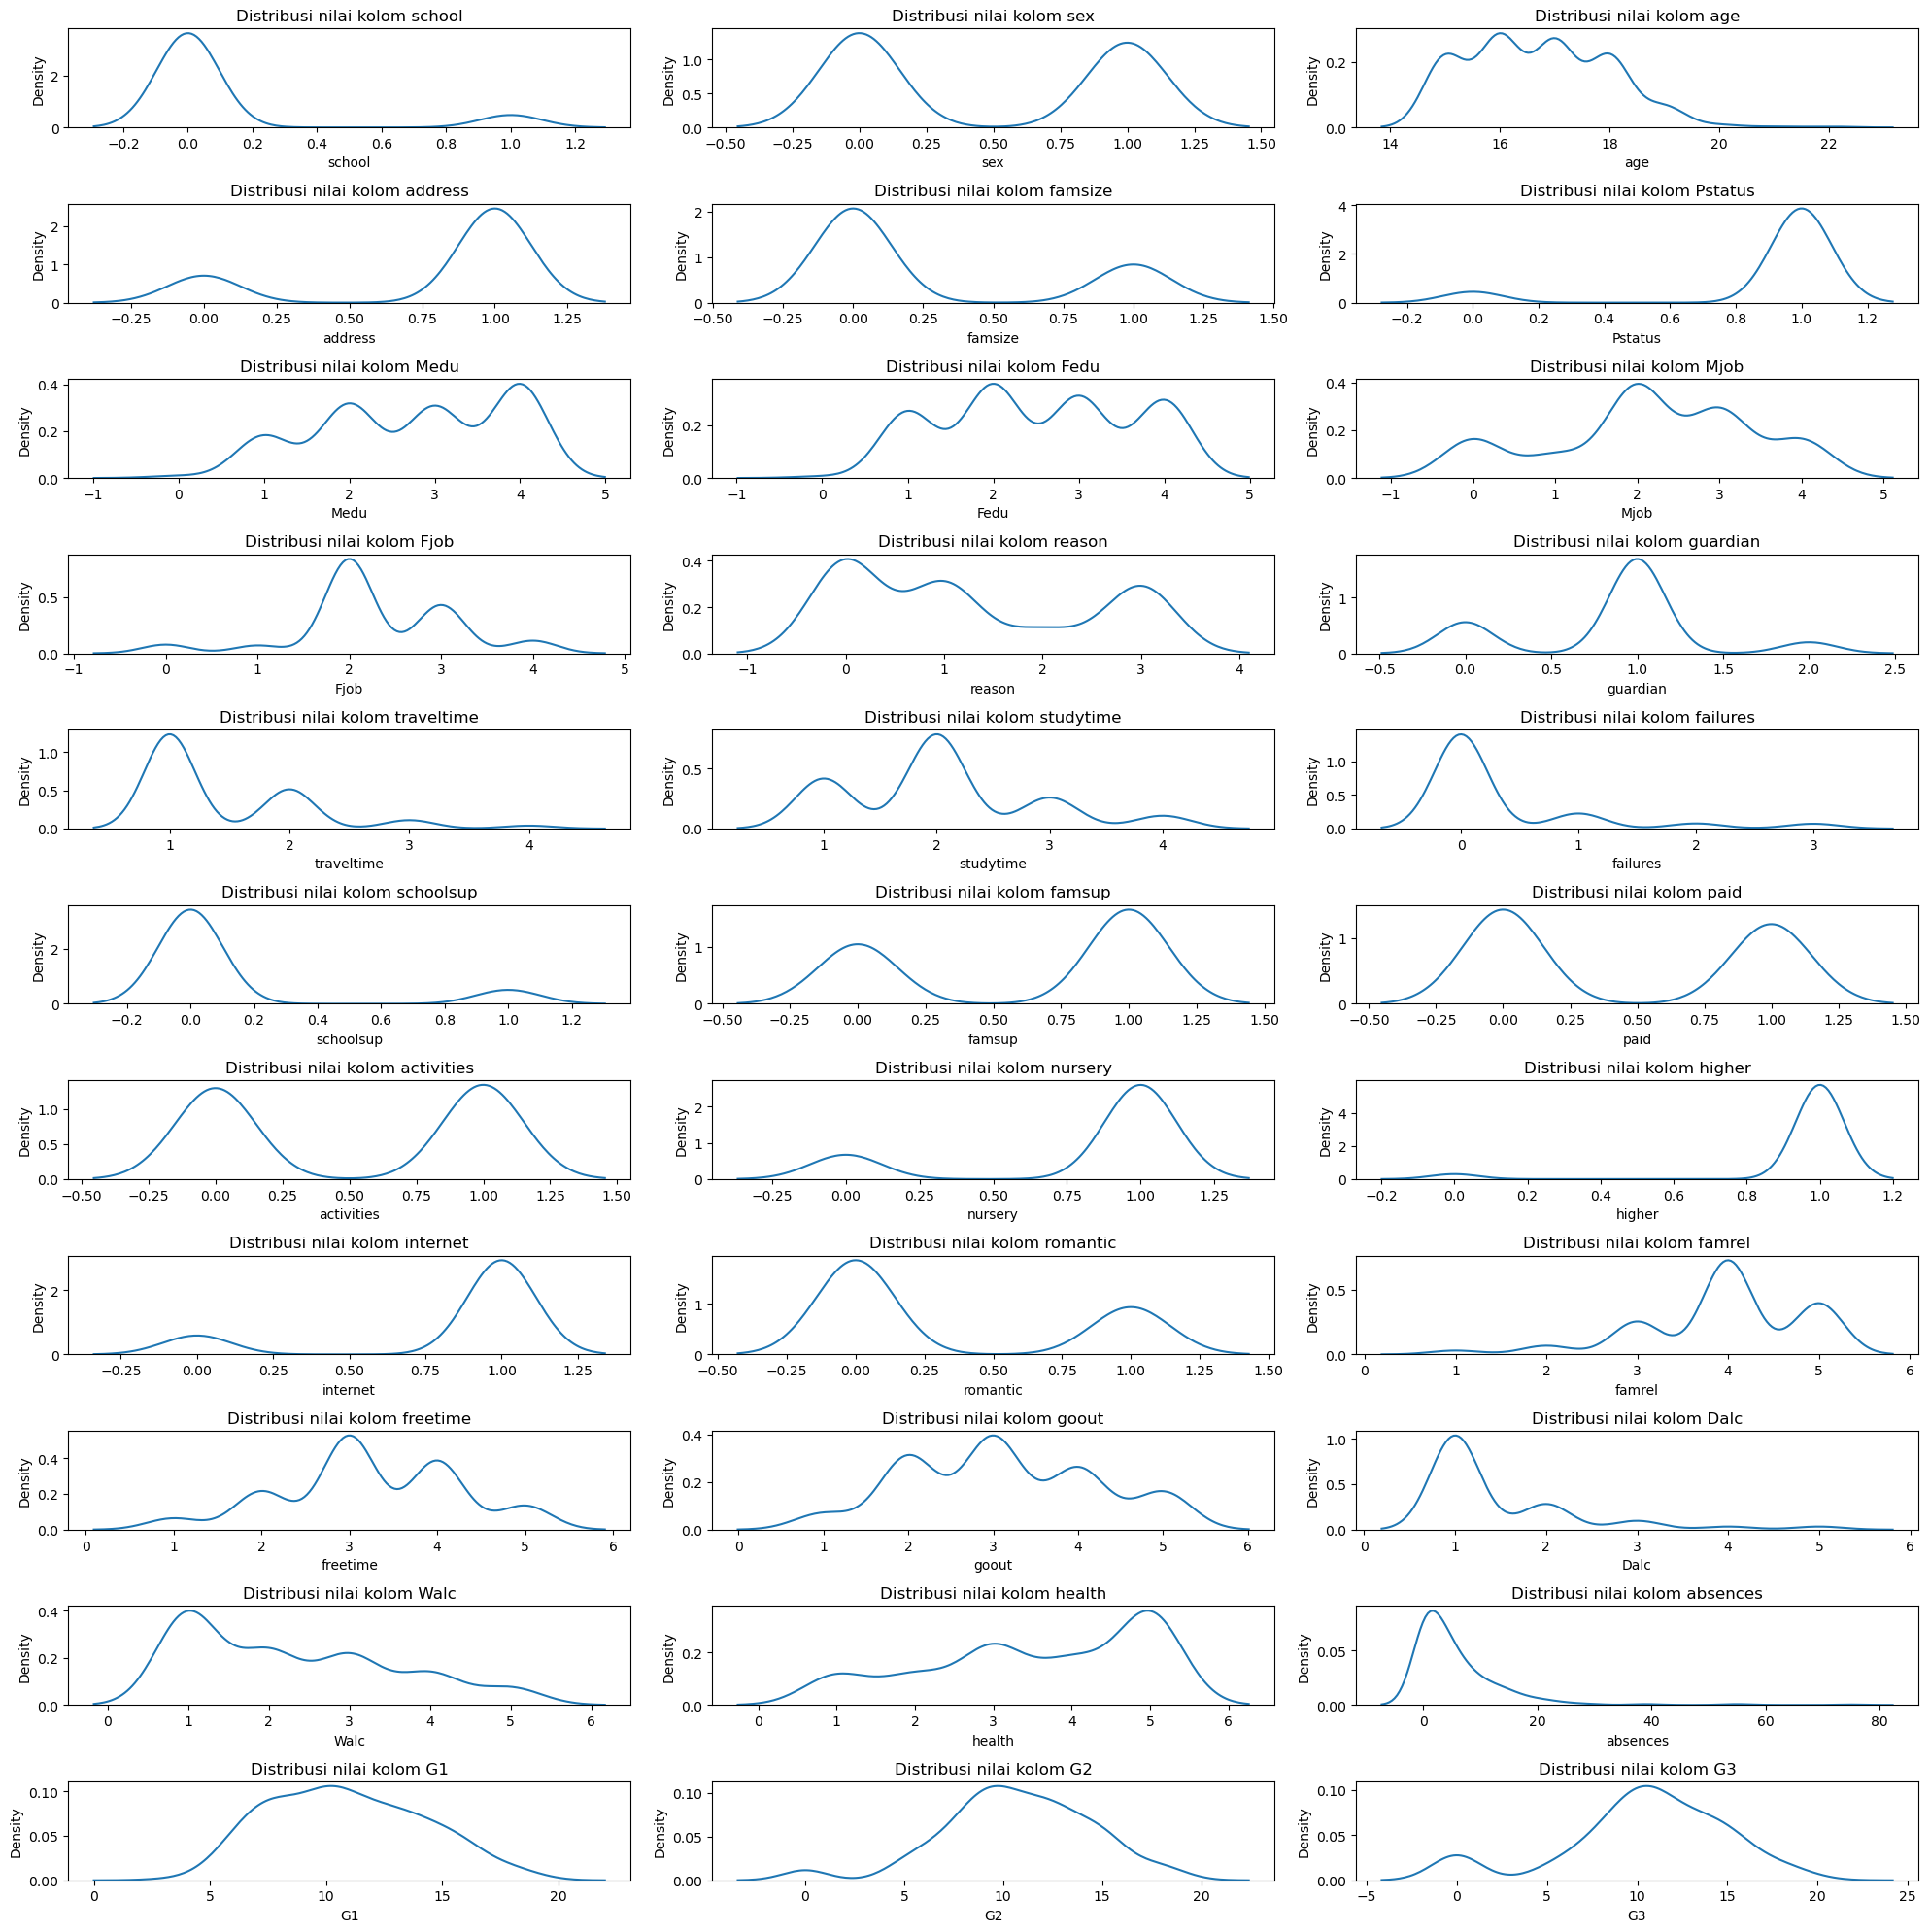

In [13]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col]) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

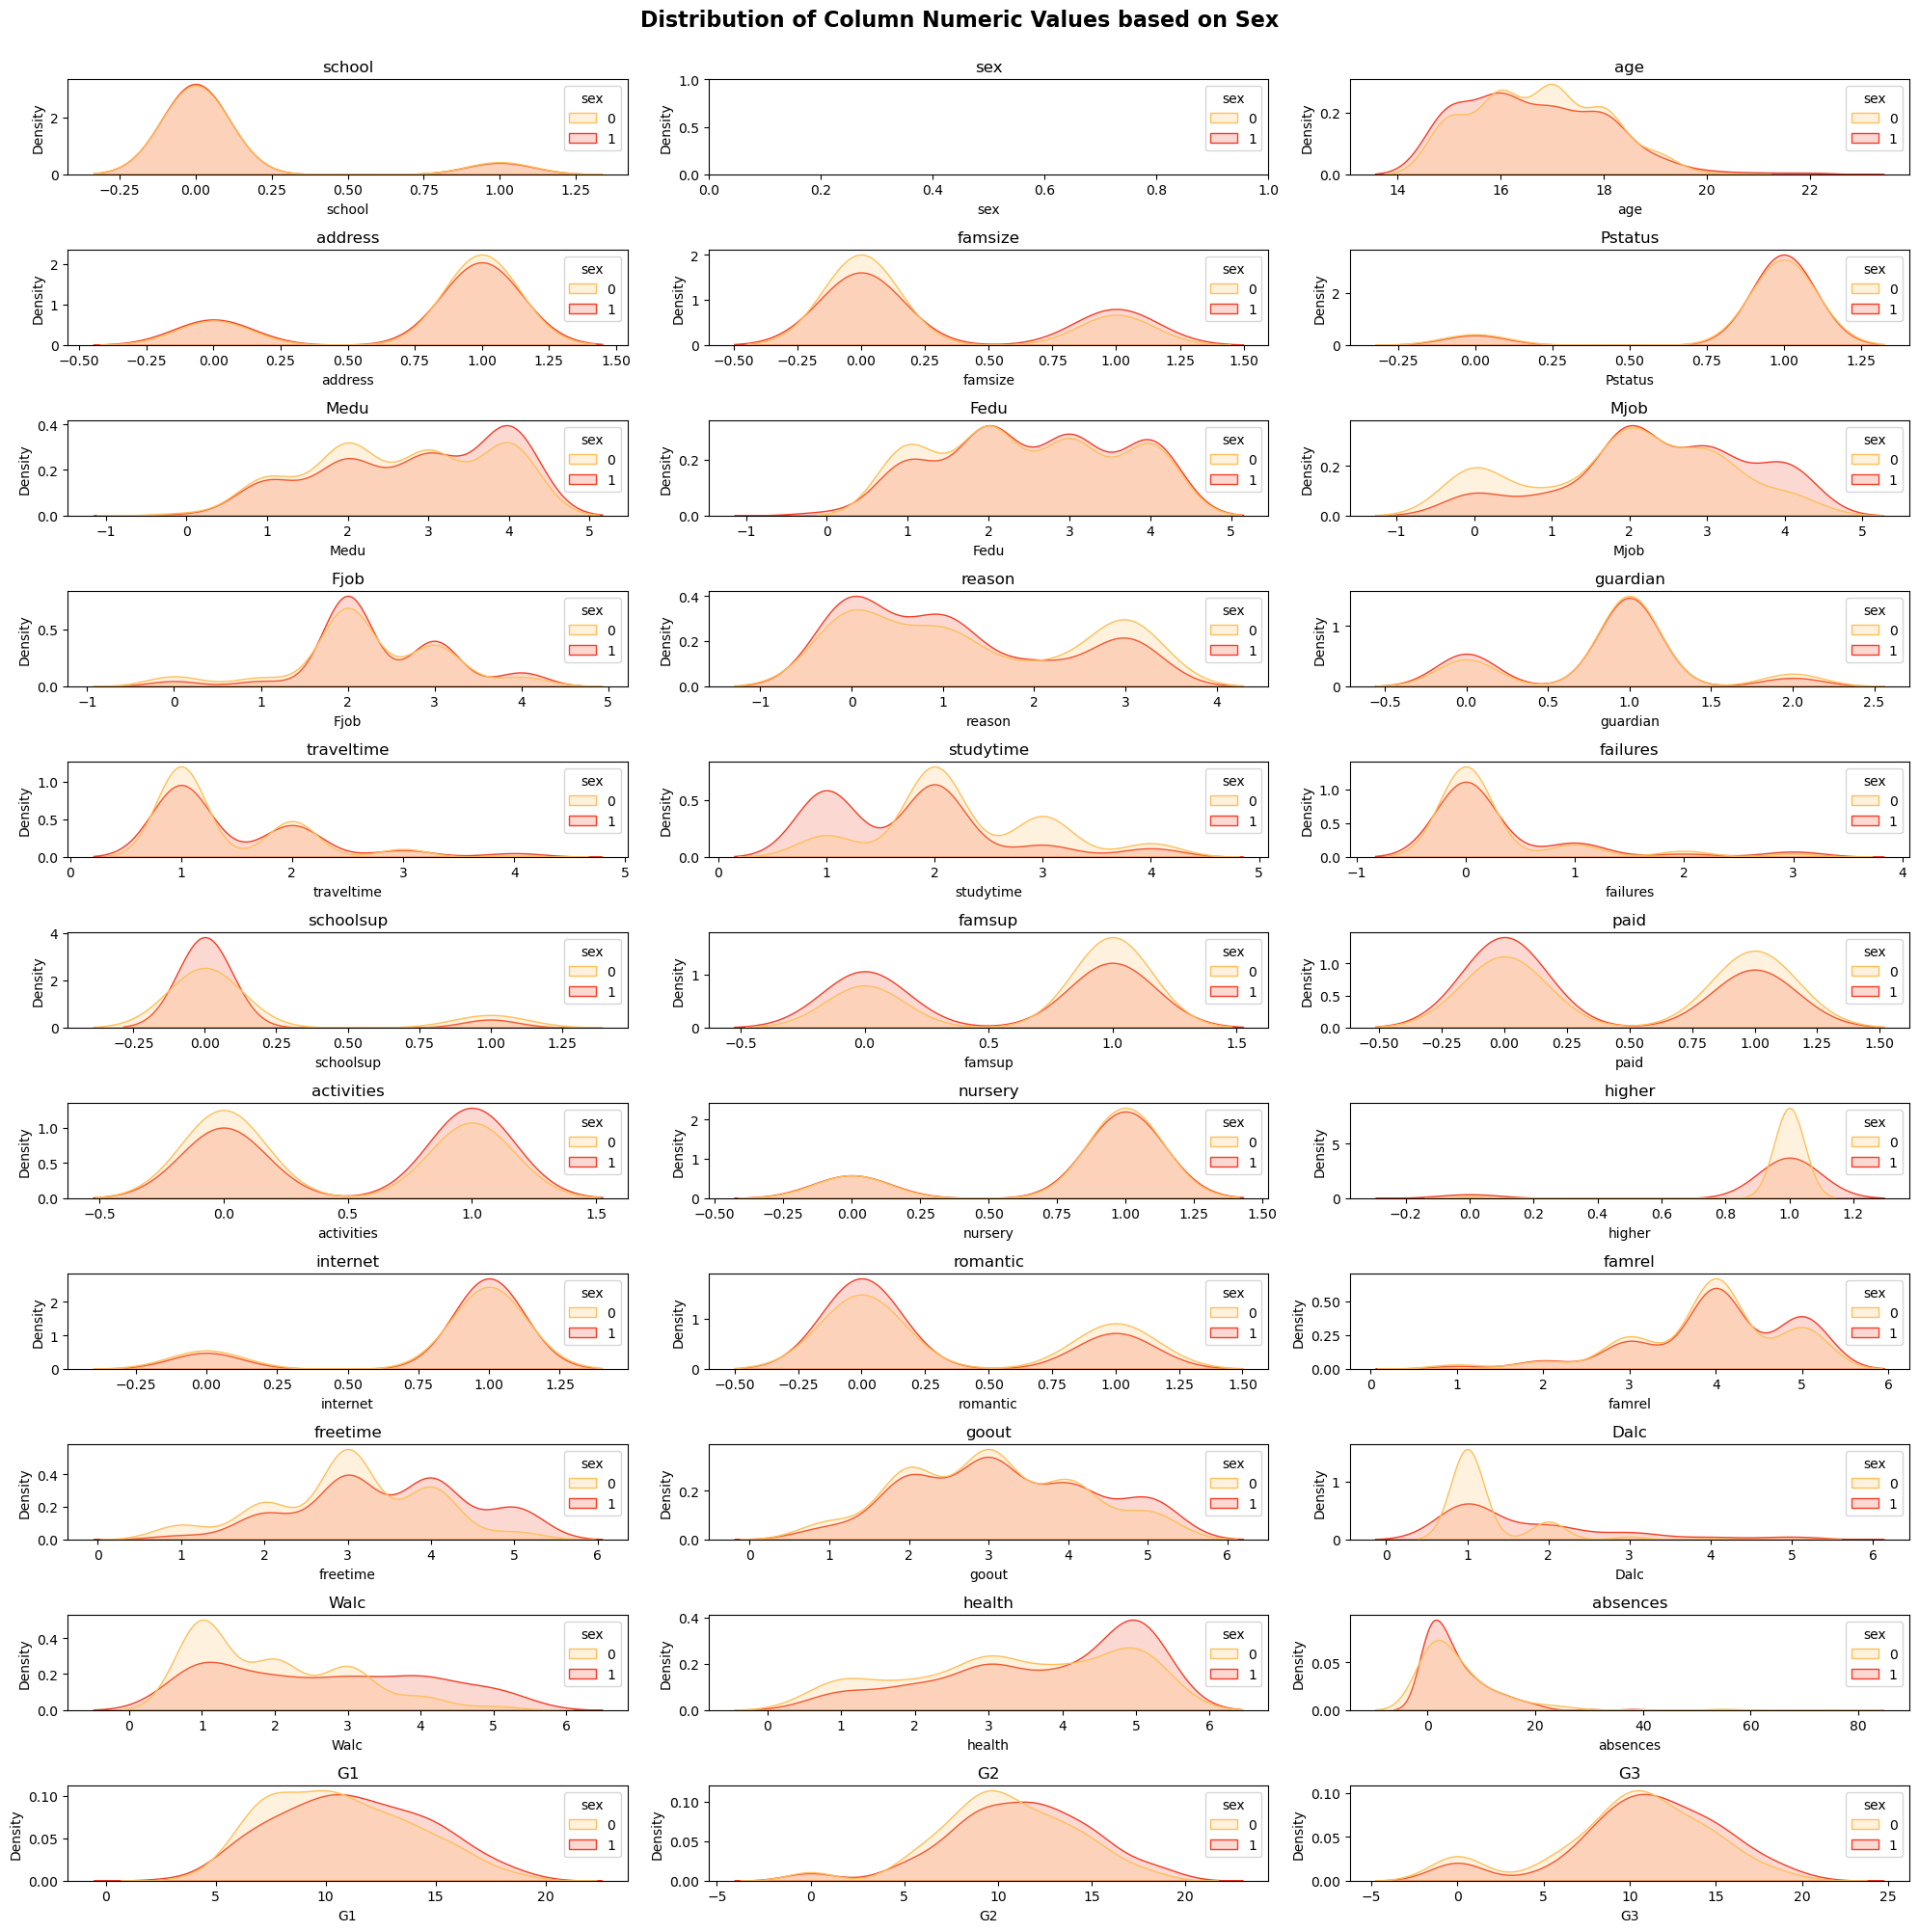

In [14]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=data, x=column, hue="sex", 
                fill=True, alpha=.2, palette="YlOrRd", 
                common_norm=False, ax=axes[row, col],
                warn_singular=False)\
        .set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Sex', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

[Text(0, 0, '38'),
 Text(0, 0, '1'),
 Text(0, 0, '7'),
 Text(0, 0, '15'),
 Text(0, 0, '9'),
 Text(0, 0, '32'),
 Text(0, 0, '28'),
 Text(0, 0, '56'),
 Text(0, 0, '47'),
 Text(0, 0, '31'),
 Text(0, 0, '31'),
 Text(0, 0, '27'),
 Text(0, 0, '33'),
 Text(0, 0, '16'),
 Text(0, 0, '6'),
 Text(0, 0, '12'),
 Text(0, 0, '5'),
 Text(0, 0, '1')]

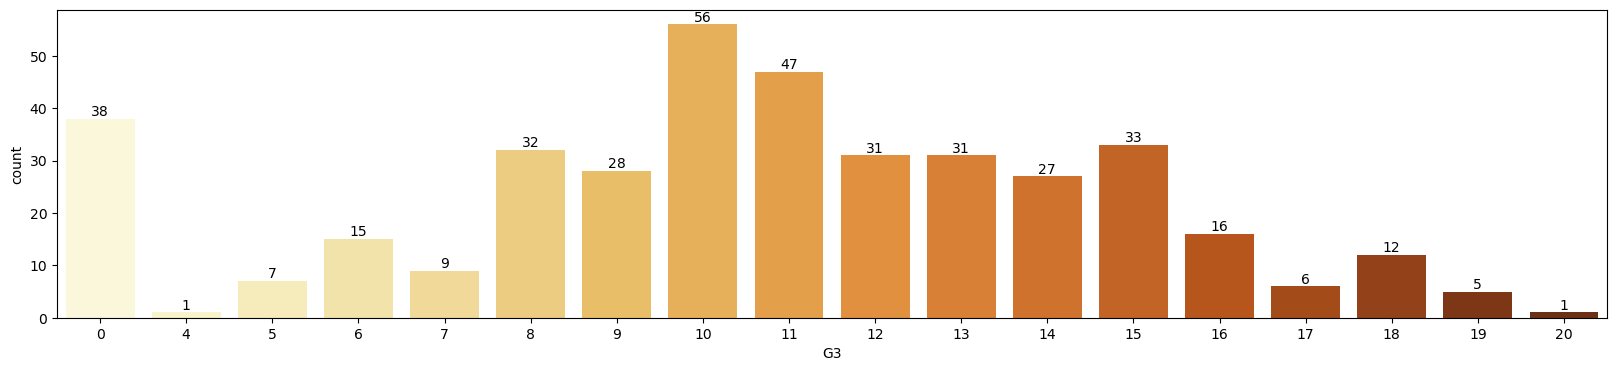

In [15]:
plt.subplots(figsize = (20,4))
ax = sns.countplot(data = data, x = 'G3', palette='YlOrBr')
ax.bar_label(ax.containers[0])

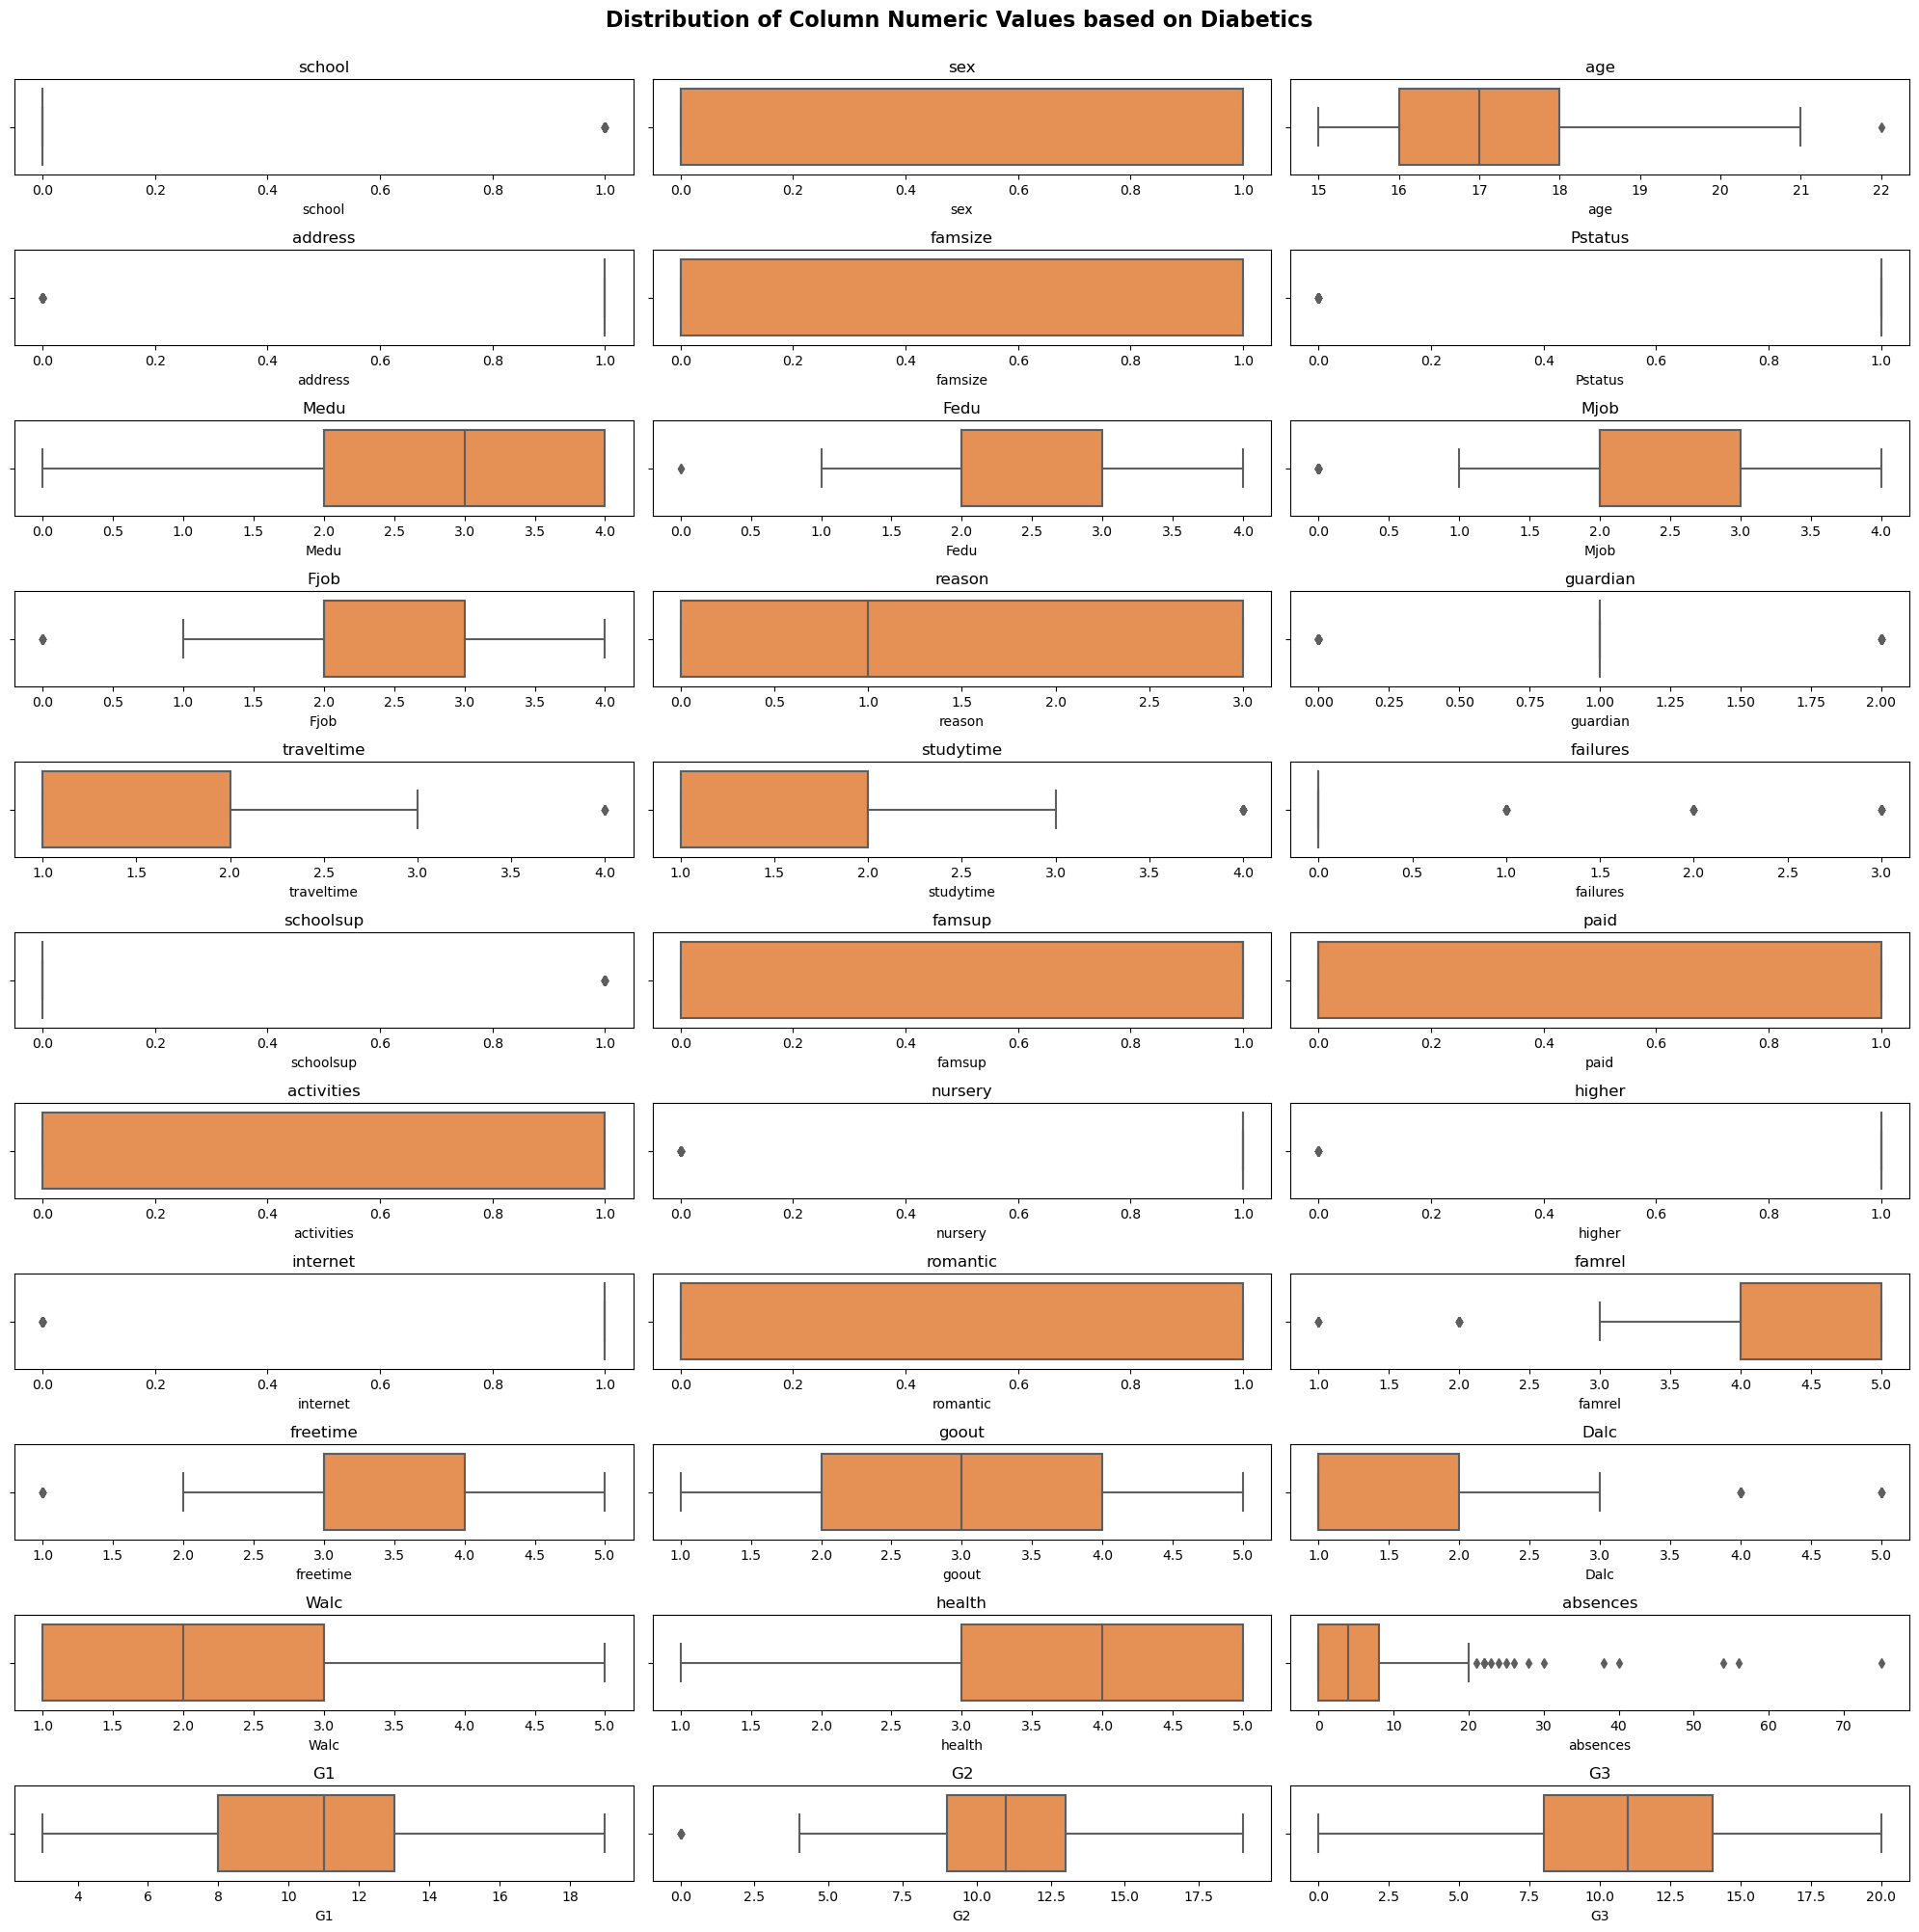

In [17]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Diabetics', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

Text(0.5, 1.0, 'Correlation Matrix')

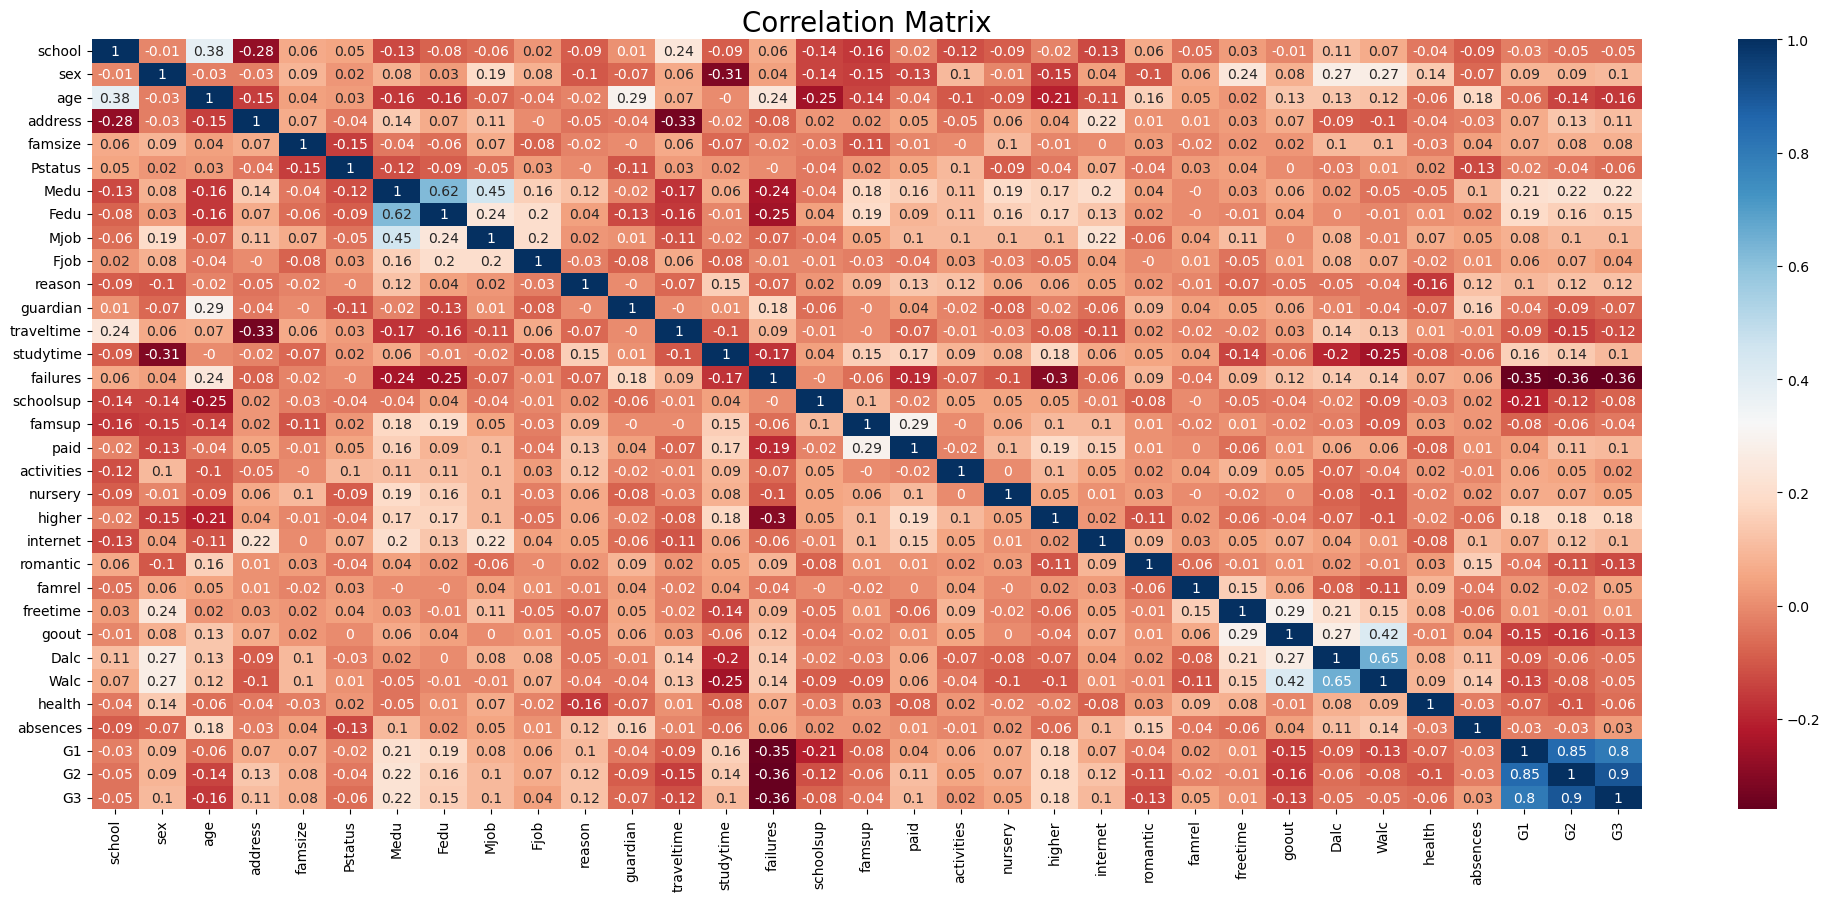

In [18]:
corr_data = data.corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 4. Data Preprocessing

### 4.2. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


### 4.2. Splitting Train, Test, And Validation data 

In [35]:
X = data.drop(columns=['G3'])
Y = data['G3']

# print(Counter(Y))
# undersample = RandomUnderSampler()
# X, Y = undersample.fit_resample(X, Y)
# print(Counter(Y))

# Y = to_categorical(Y)

# scaler = MinMaxScaler(feature_range=(0,1))
# X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)
X_val = scalar.transform(X_val)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(276, 32)
(79, 32)
(40, 32)


### 4.3. Neural Network Algoritms

In [36]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform', input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    # model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear', kernel_initializer='he_uniform'))
    
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    model.add(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True))
    model.add(GRU(32, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

# model = DNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

# opt = SGD(learning_rate=0.01, momentum=0.9)
opt = Adam(learning_rate = 0.0001)

# model.compile(loss='mse', optimizer=opt, metrics=['mse'])
model.compile(loss='mae', optimizer = opt)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 32, 128)           50304     
                                                                 
 gru_4 (GRU)                 (None, 32, 64)            37248     
                                                                 
 gru_5 (GRU)                 (None, 32)                9408      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 96,993
Trainable params: 96,993
Non-trainable params: 0
_________________________________________________________________


In [37]:
num_epoch = 100
batch_size = 32

history = model.fit(X_train, y_train, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_test, y_test))

Epoch 1/100
9/9 [==============================] - 3s 105ms/step - loss: 10.3434 - val_loss: 10.5984
Epoch 2/100
9/9 [==============================] - 0s 16ms/step - loss: 10.2968 - val_loss: 10.5424
Epoch 3/100
9/9 [==============================] - 0s 16ms/step - loss: 10.2452 - val_loss: 10.4785
Epoch 4/100
9/9 [==============================] - 0s 17ms/step - loss: 10.1816 - val_loss: 10.3970
Epoch 5/100
9/9 [==============================] - 0s 15ms/step - loss: 10.0973 - val_loss: 10.2835
Epoch 6/100
9/9 [==============================] - 0s 15ms/step - loss: 9.9779 - val_loss: 10.1104
Epoch 7/100
9/9 [==============================] - 0s 15ms/step - loss: 9.7872 - val_loss: 9.8322
Epoch 8/100
9/9 [==============================] - 0s 15ms/step - loss: 9.4730 - val_loss: 9.3479
Epoch 9/100
9/9 [==============================] - 0s 15ms/step - loss: 8.8933 - val_loss: 8.4532
Epoch 10/100
9/9 [==============================] - 0s 15ms/step - loss: 7.8232 - val_loss: 6.9123
Epoch 1

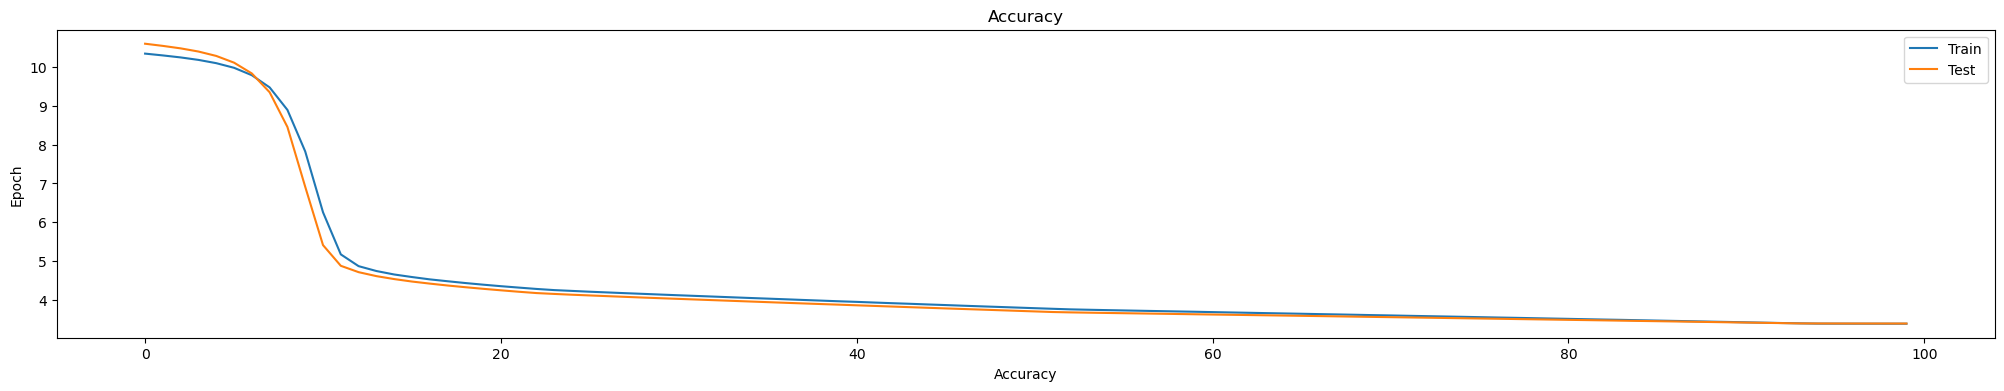

In [38]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [39]:
y_pred = model.predict(X_test, verbose = 0)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))

R Squared Error    : -0.02
Mean Squared Error : 20.65


In [41]:
train_predictions = np.rint(model.predict(X_test, verbose=0)).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].mean(), '-', (train_results['Diff'].sum()))

     Train Predictions  Actuals  Diff
240               10.0       12   2.0
63                10.0        9   1.0
288               10.0       14   4.0
2                 10.0       10   0.0
75                10.0       10   0.0
3.392405063291139 - 268.0


### 4.4. Supervised Learning

In [51]:
adaboost = AdaBoostRegressor(n_estimators = 100, random_state = 42)
bagging = BaggingRegressor(n_jobs = -1)
extraTrees = ExtraTreesRegressor(max_depth = 100, n_jobs = -1, random_state = 42)
gradient = GradientBoostingRegressor(max_depth = 100, n_estimators = 100, learning_rate = .01,  random_state = 0)
randomForest = RandomForestRegressor(max_depth = 100, random_state = 42, n_jobs = -1)
histGradient = HistGradientBoostingRegressor()
XGB = XGBRegressor(n_jobs = -1)
knn = KNeighborsRegressor(n_jobs = -1)
decisionTree = DecisionTreeRegressor( max_depth = 100, random_state = 42)

model = StackingRegressor([
    ('extraTrees', extraTrees),
    ('knn', knn),
    ('histGradient', histGradient),
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('randomforest', randomForest),
    ('XGB', XGB),
    ('decisionTree', decisionTree),
    ('gradient', gradient),
], n_jobs=-1)

In [52]:
model.fit(X_train, y_train)

StackingRegressor(estimators=[('extraTrees',
                               ExtraTreesRegressor(max_depth=100, n_jobs=-1,
                                                   random_state=42)),
                              ('knn', KNeighborsRegressor(n_jobs=-1)),
                              ('histGradient', HistGradientBoostingRegressor()),
                              ('adaboost',
                               AdaBoostRegressor(n_estimators=100,
                                                 random_state=42)),
                              ('bagging', BaggingRegressor(n_jobs=-1)),
                              ('randomforest',
                               RandomForestRegressor(max_depth=100...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                              ('decisionTree',
                               DecisionTreeRegressor(max_depth=100,
                                                     random_state=42)),
                              ('gradient',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=100,
                                                         random_state=0))],
                  n_jobs=-1)

In [53]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))

Train Score        : 99.32 %
Test Score         : 88.0 %
R Squared Error    : 0.88
Mean Squared Error : 2.44


In [54]:
train_predictions = np.rint(model.predict(X_test)).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].mean(), '-', (train_results['Diff'].sum()))

     Train Predictions  Actuals  Diff
240               12.0       12   0.0
63                 9.0        9   0.0
288               15.0       14   1.0
2                  8.0       10   2.0
75                 9.0       10   1.0
0.8987341772151899 - 71.0
